In [52]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn import preprocessing
import lightgbm as lgb

from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm


import warnings
warnings.simplefilter('ignore')

In [53]:
train_data = pd.read_csv('../data/sales_train_evaluation.csv')
calendar = pd.read_csv('../data/calendar.csv')
prices = pd.read_csv('../data/sell_prices.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [54]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        #valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
        #                       .columns.tolist()
        
        valid_target_columns = valid_df.columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()
        
        print(weight_df)

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            print(lv_weight / lv_weight.sum())
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [55]:
train_fold_df = train_data.iloc[:, :-28]
valid_fold_df = train_data.iloc[:, -28:]

#valid_fold_df.rename({f'd_{1913+i}':f'F{i}' for i in range(1,29)}, axis=1, inplace=True)
valid_preds = pd.read_csv('../result/linear_cat_and_store_rm_all_submission.csv')

valid_preds['is_valid'] = valid_preds['id'].apply(lambda x: 1 if '_validation' in x else 0)
valid_preds.rename({f'F{i}':f'd_{1913+i}' for i in range(1,29)}, axis=1, inplace=True)

valid_preds = submission[['id']].merge(valid_preds, on = 'id')
valid_preds = valid_preds[valid_preds.is_valid==1][valid_preds.columns.drop(['id', 'is_valid'])].copy()

In [56]:
evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)
evaluator.score(valid_preds)

                                  id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id all_id  d_1886  d_1887  d_1888  ...  d_1904  d_1905  \
0         CA_1      

  0%|          | 0/12 [00:00<?, ?it/s]

all_id
all    1.0
dtype: float64
state_id
CA    0.442371
TX    0.269297
WI    0.288332
dtype: float64
store_id
CA_1    0.110888
CA_2    0.110247
CA_3    0.155628
CA_4    0.065608
TX_1    0.077561
TX_2    0.095201
TX_3    0.096535
WI_1    0.087117
WI_2    0.116622
WI_3    0.084593
dtype: float64
cat_id
FOODS        0.568586
HOBBIES      0.128079
HOUSEHOLD    0.303335
dtype: float64
dept_id
FOODS_1        0.062625
FOODS_2        0.154642
FOODS_3        0.351318
HOBBIES_1      0.122088
HOBBIES_2      0.005991
HOUSEHOLD_1    0.229594
HOUSEHOLD_2    0.073741
dtype: float64
state_id  cat_id   
CA        FOODS        0.240745
          HOBBIES      0.058855
          HOUSEHOLD    0.142772
TX        FOODS        0.141583
          HOBBIES      0.041293
          HOUSEHOLD    0.086420
WI        FOODS        0.186258
          HOBBIES      0.027931
          HOUSEHOLD    0.074143
dtype: float64
state_id  dept_id    
CA        FOODS_1        0.027055
          FOODS_2        0.057655
          FO

0.7655902739346949

In [37]:
evaluator.lv12_weight.reset_index().to_csv('../data/weight_df.csv', index=False)

In [40]:
evaluator.lv12_weight

item_id          store_id
FOODS_1_001      CA_1        1.972157e-05
                 CA_2        1.852632e-05
                 CA_3        1.434296e-05
                 CA_4        5.378610e-06
                 TX_1        5.976234e-07
                                 ...     
HOUSEHOLD_2_516  TX_2        1.267815e-05
                 TX_3        7.923846e-06
                 WI_1        1.584769e-06
                 WI_2        1.584769e-06
                 WI_3        0.000000e+00
Length: 30490, dtype: float64

In [49]:
### 生成1913的weight_scale_df
import math
weight_scale_df = evaluator.lv12_weight.reset_index()
weight_scale_df.rename({0: 'weight'}, axis=1, inplace=True)
weight_scale_df['scale'] = [math.sqrt(scale) for scale in evaluator.lv12_scale]

In [50]:
weight_scale_df.to_csv('../data/weight_scale_df.csv', index=False)

In [51]:
weight_scale_df

item_id store_id        weight     scale
0          FOODS_1_001     CA_1  1.972157e-05  1.709407
1          FOODS_1_001     CA_2  1.852632e-05  2.395952
2          FOODS_1_001     CA_3  1.434296e-05  3.193465
3          FOODS_1_001     CA_4  5.378610e-06  1.009634
4          FOODS_1_001     TX_1  5.976234e-07  1.860521
...                ...      ...           ...       ...
30485  HOUSEHOLD_2_516     TX_2  1.267815e-05  0.786796
30486  HOUSEHOLD_2_516     TX_3  7.923846e-06  0.473127
30487  HOUSEHOLD_2_516     WI_1  1.584769e-06  0.413877
30488  HOUSEHOLD_2_516     WI_2  1.584769e-06  0.264323
30489  HOUSEHOLD_2_516     WI_3  0.000000e+00  0.530099

[30490 rows x 4 columns]

In [57]:
### 生成1941的weight_scale_df
train_fold_df = train_data
valid_fold_df = train_data.iloc[:, -28:]

#valid_fold_df.rename({f'd_{1913+i}':f'F{i}' for i in range(1,29)}, axis=1, inplace=True)
valid_preds = pd.read_csv('../result/linear_cat_and_store_rm_all_submission.csv')

valid_preds['is_valid'] = valid_preds['id'].apply(lambda x: 1 if '_validation' in x else 0)
valid_preds.rename({f'F{i}':f'd_{1913+i}' for i in range(1,29)}, axis=1, inplace=True)

valid_preds = submission[['id']].merge(valid_preds, on = 'id')
valid_preds = valid_preds[valid_preds.is_valid==1][valid_preds.columns.drop(['id', 'is_valid'])].copy()

evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)
evaluator.score(valid_preds)

                                  id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id all_id  d_1914  d_1915  d_1916  ...  d_1932  d_1933  \
0         CA_1      

  0%|          | 0/12 [00:00<?, ?it/s]

all_id
all    1.0
dtype: float64
state_id
CA    0.441376
TX    0.275960
WI    0.282664
dtype: float64
store_id
CA_1    0.111262
CA_2    0.112476
CA_3    0.151351
CA_4    0.066286
TX_1    0.079001
TX_2    0.096070
TX_3    0.100890
WI_1    0.086696
WI_2    0.113112
WI_3    0.082856
dtype: float64
cat_id
FOODS        0.573037
HOBBIES      0.129003
HOUSEHOLD    0.297960
dtype: float64
dept_id
FOODS_1        0.072616
FOODS_2        0.146850
FOODS_3        0.353571
HOBBIES_1      0.121992
HOBBIES_2      0.007012
HOUSEHOLD_1    0.223239
HOUSEHOLD_2    0.074720
dtype: float64
state_id  cat_id   
CA        FOODS        0.240476
          HOBBIES      0.058168
          HOUSEHOLD    0.142731
TX        FOODS        0.147846
          HOBBIES      0.043132
          HOUSEHOLD    0.084983
WI        FOODS        0.184715
          HOBBIES      0.027703
          HOUSEHOLD    0.070246
dtype: float64
state_id  dept_id    
CA        FOODS_1        0.031172
          FOODS_2        0.056205
          FO

0.7787249845571438

In [58]:
import math
weight_scale_df = evaluator.lv12_weight.reset_index()
weight_scale_df.rename({0: 'weight'}, axis=1, inplace=True)
weight_scale_df['scale'] = [math.sqrt(scale) for scale in evaluator.lv12_scale]

weight_scale_df.to_csv('../data/weight_scale_df2.csv', index=False)

In [59]:
weight_scale_df

item_id store_id    weight     scale
0          FOODS_1_001     CA_1  0.000013  1.713650
1          FOODS_1_001     CA_2  0.000010  2.386604
2          FOODS_1_001     CA_3  0.000016  3.181697
3          FOODS_1_001     CA_4  0.000003  1.005144
4          FOODS_1_001     TX_1  0.000015  1.856508
...                ...      ...       ...       ...
30485  HOUSEHOLD_2_516     TX_2  0.000006  0.783402
30486  HOUSEHOLD_2_516     TX_3  0.000012  0.475156
30487  HOUSEHOLD_2_516     WI_1  0.000008  0.419578
30488  HOUSEHOLD_2_516     WI_2  0.000003  0.264367
30489  HOUSEHOLD_2_516     WI_3  0.000003  0.528214

[30490 rows x 4 columns]

In [23]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

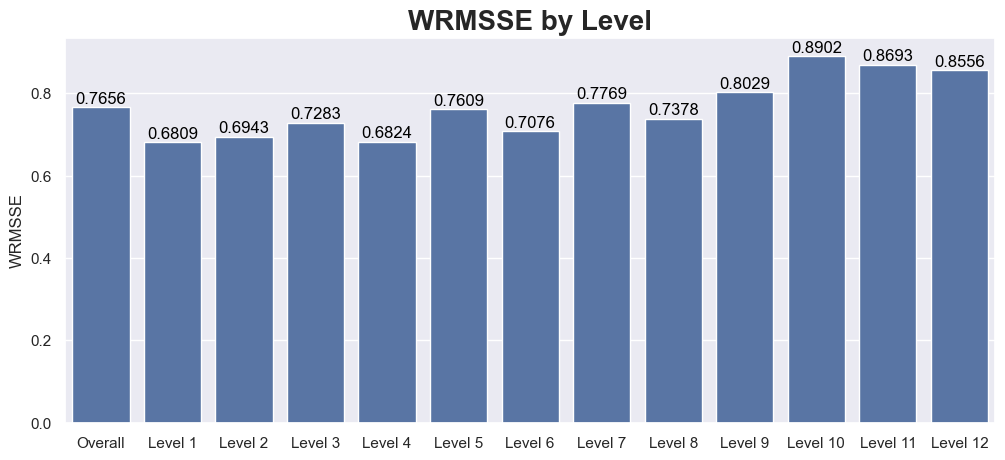

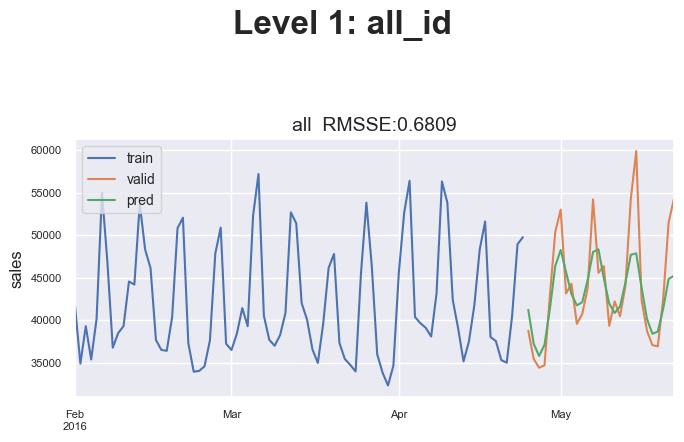

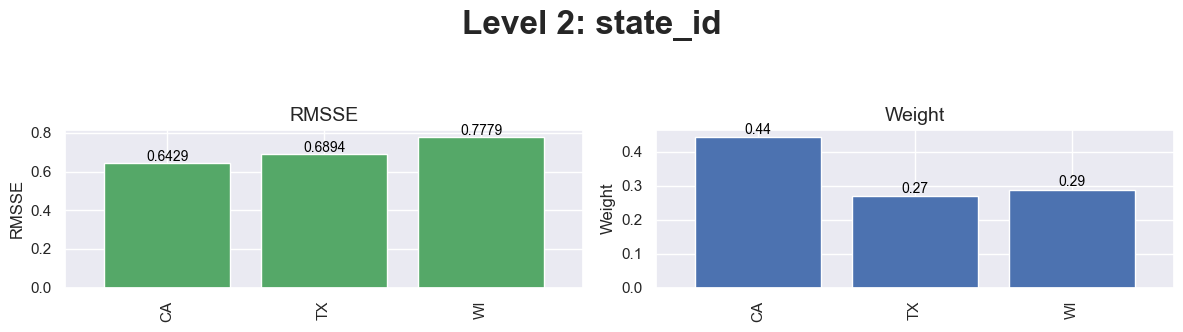

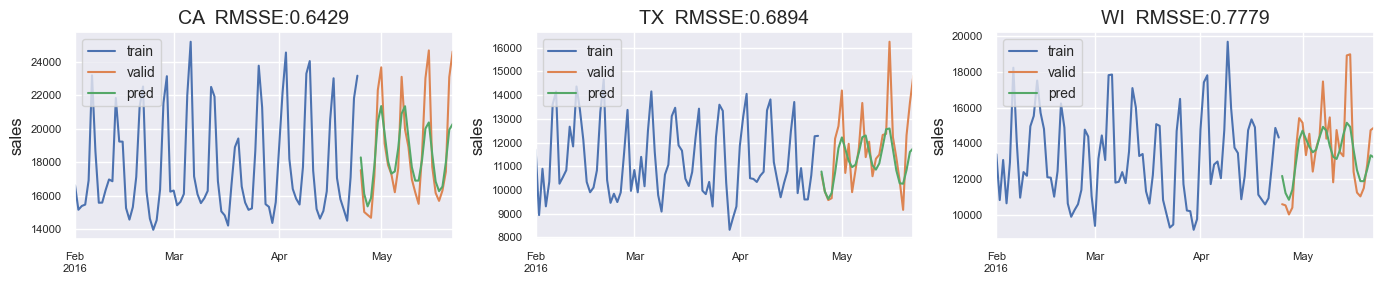

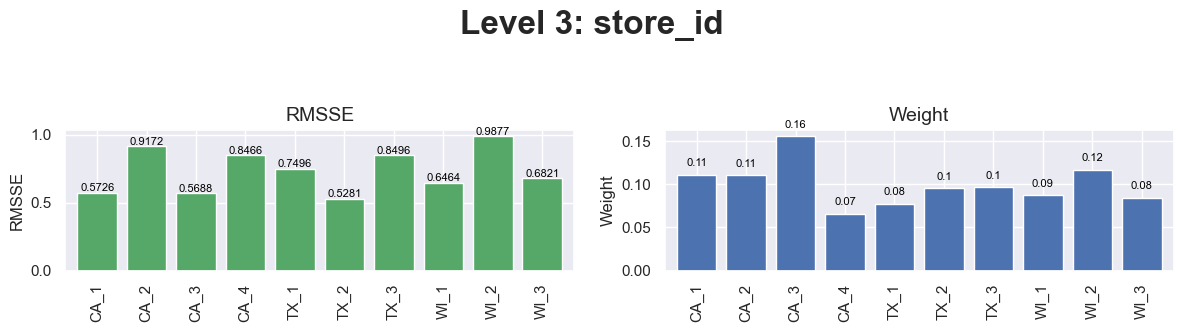

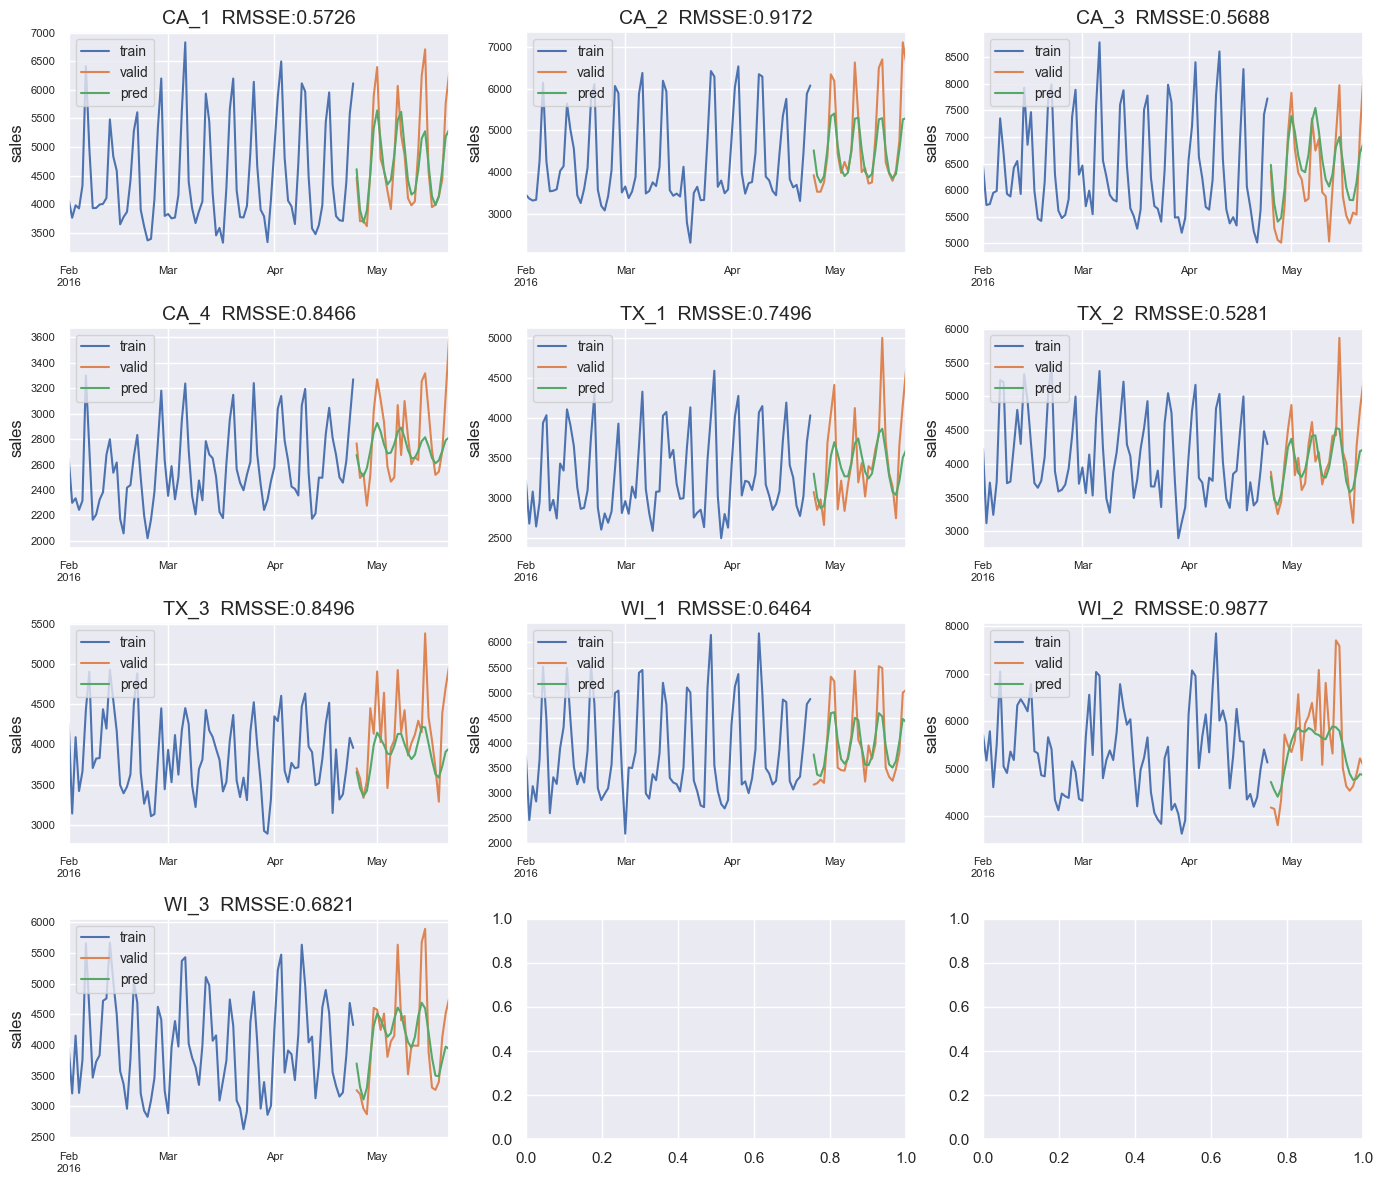

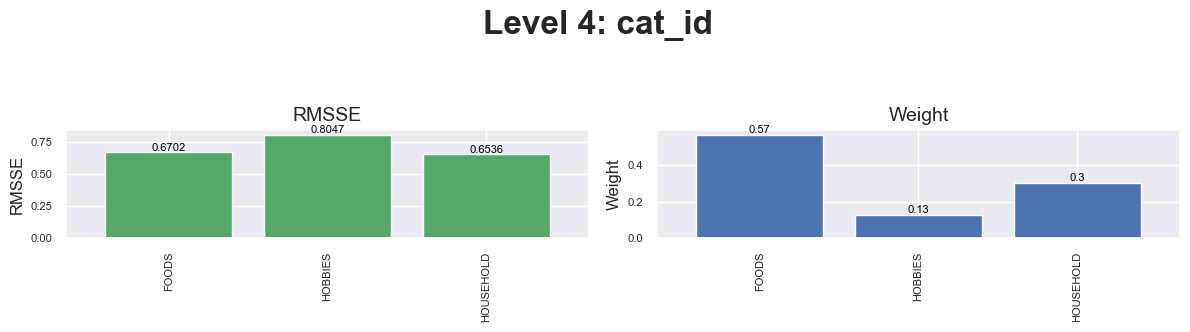

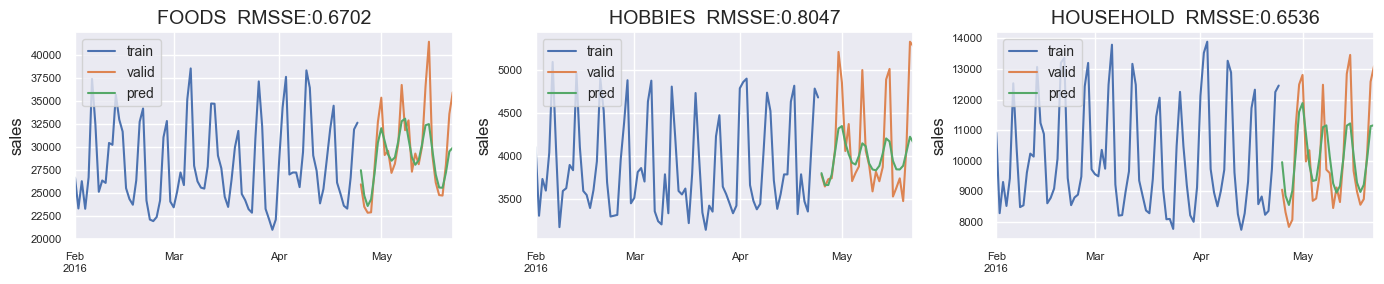

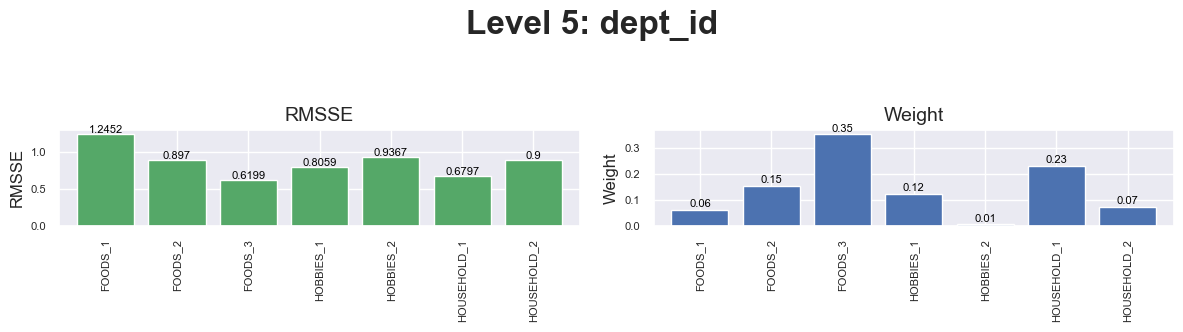

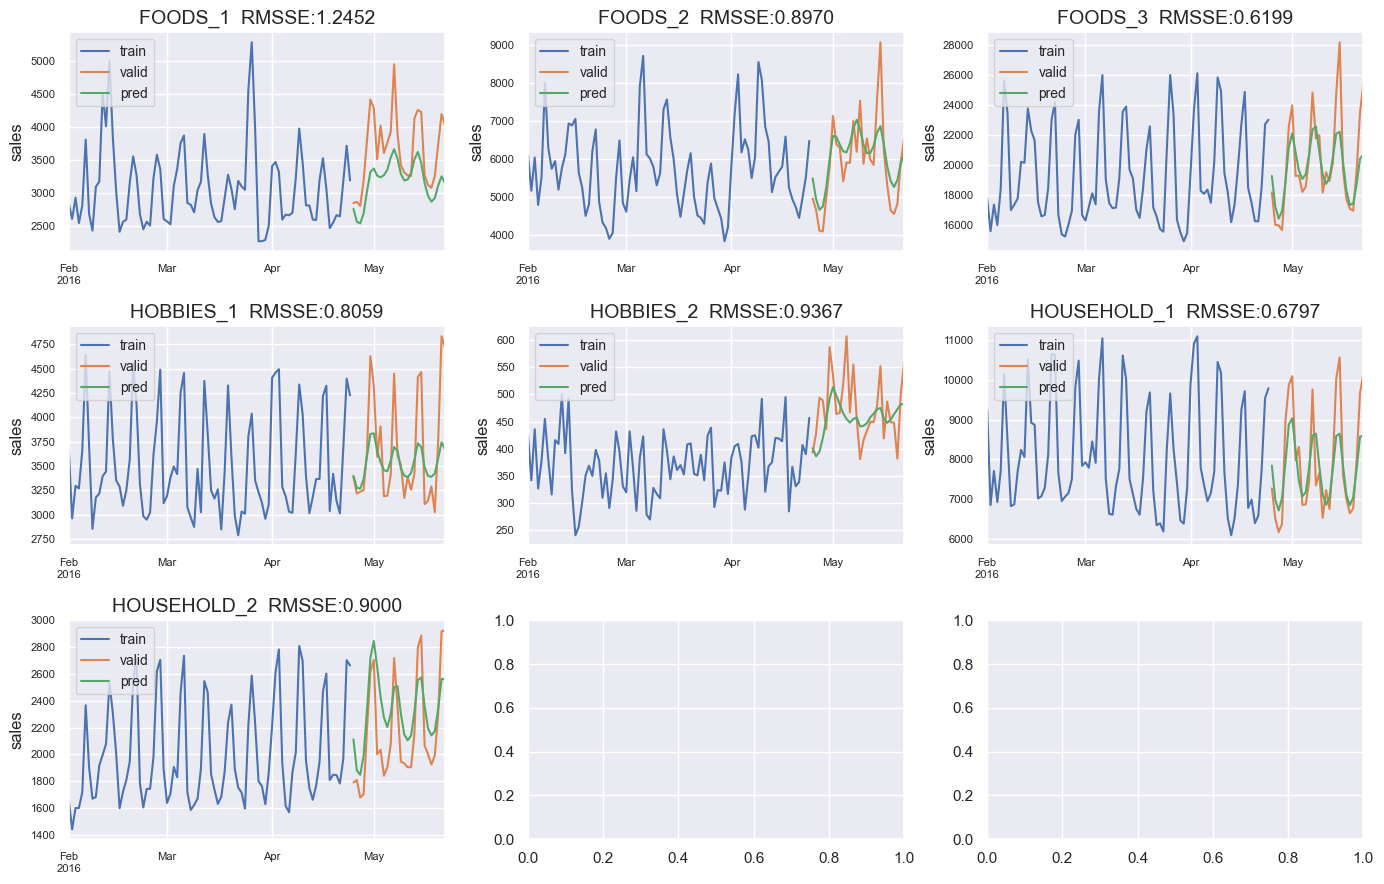

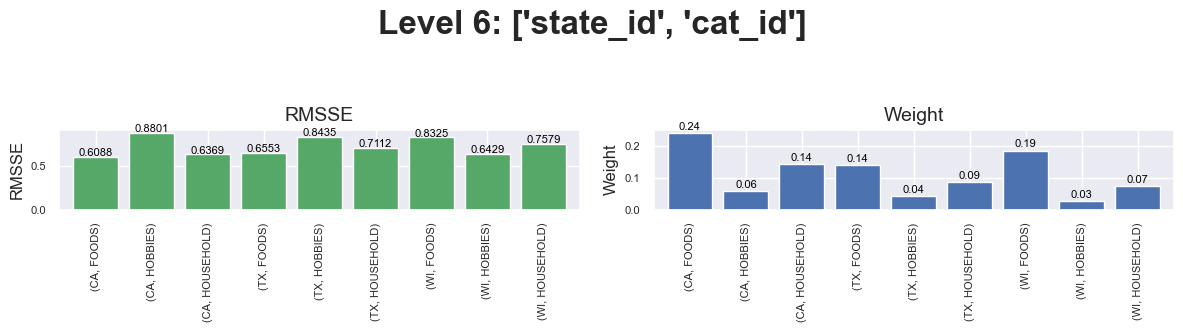

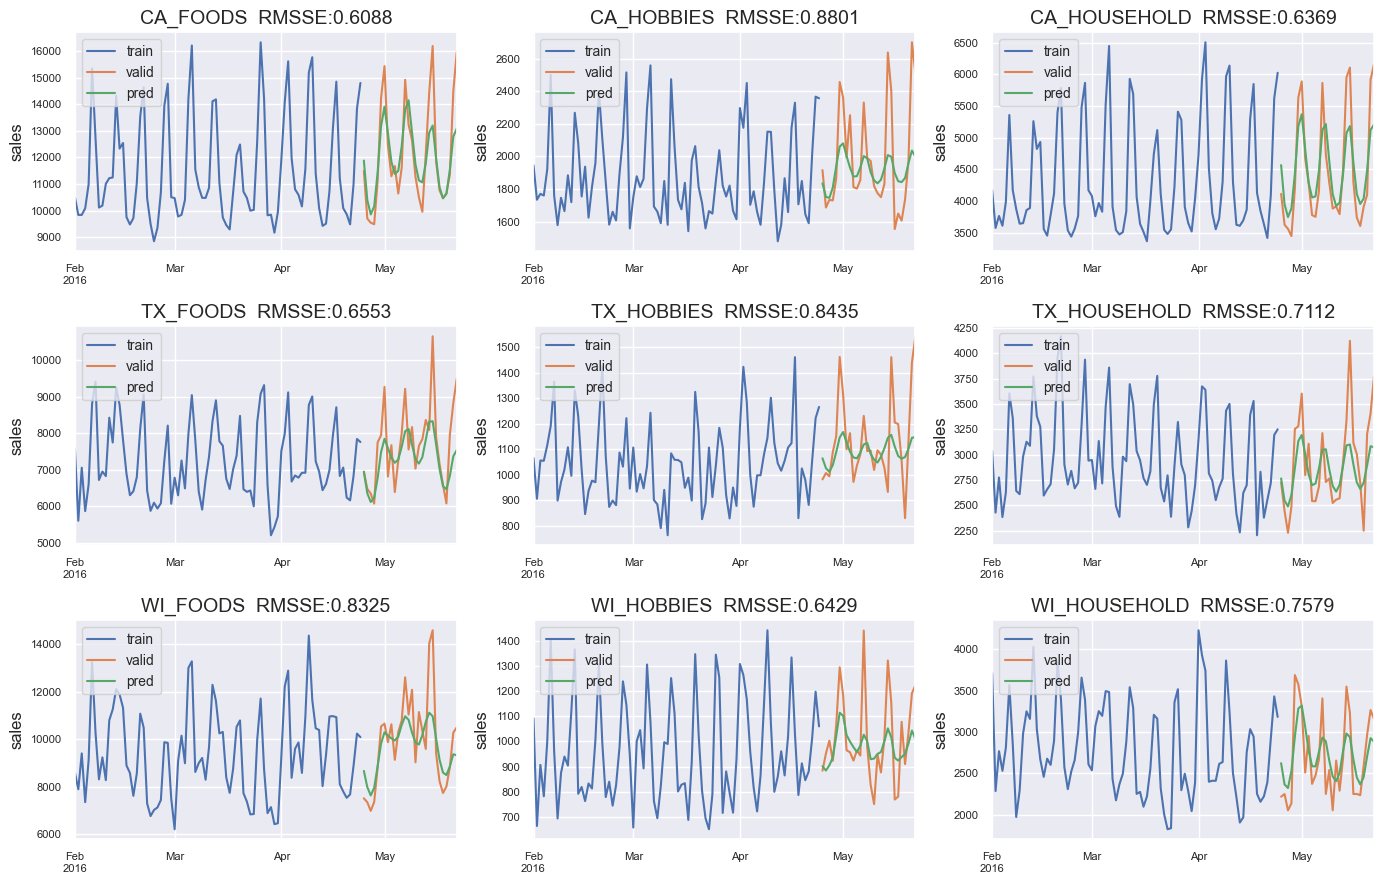

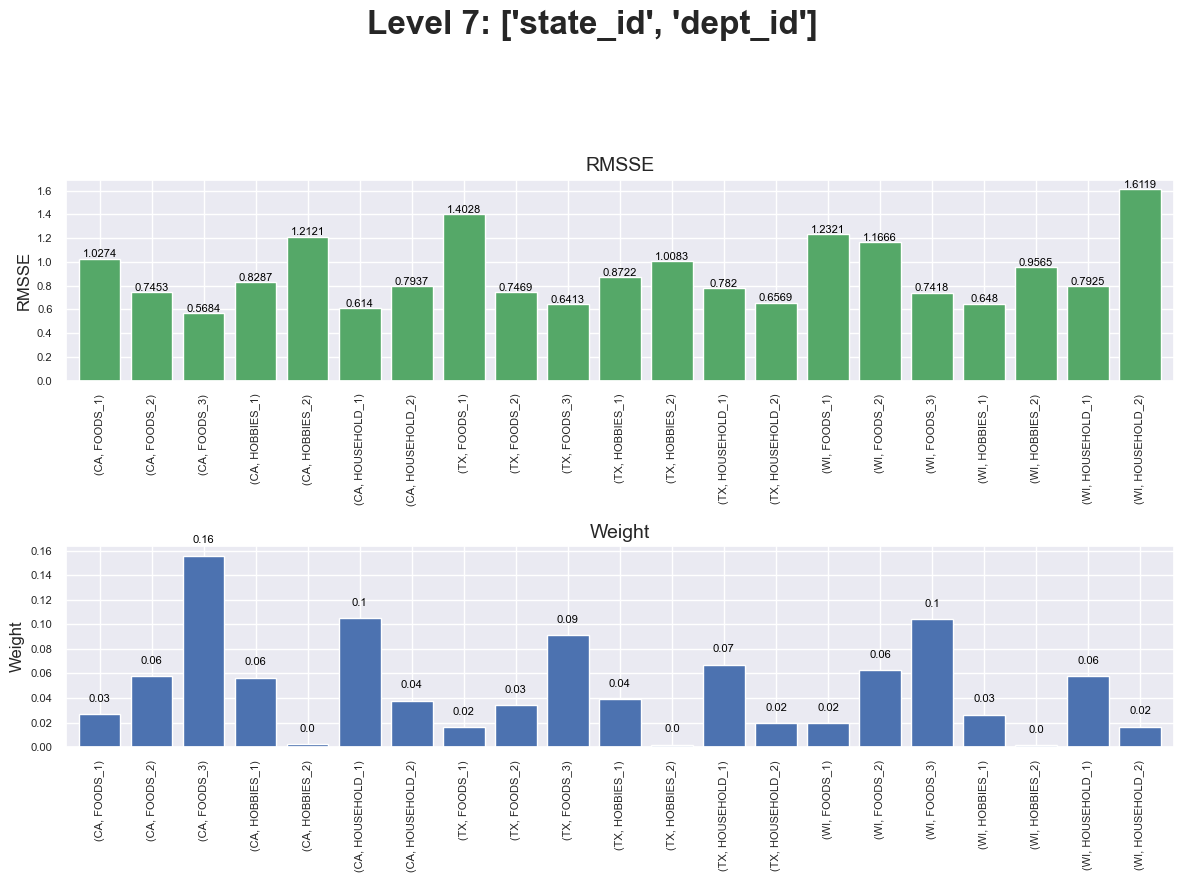

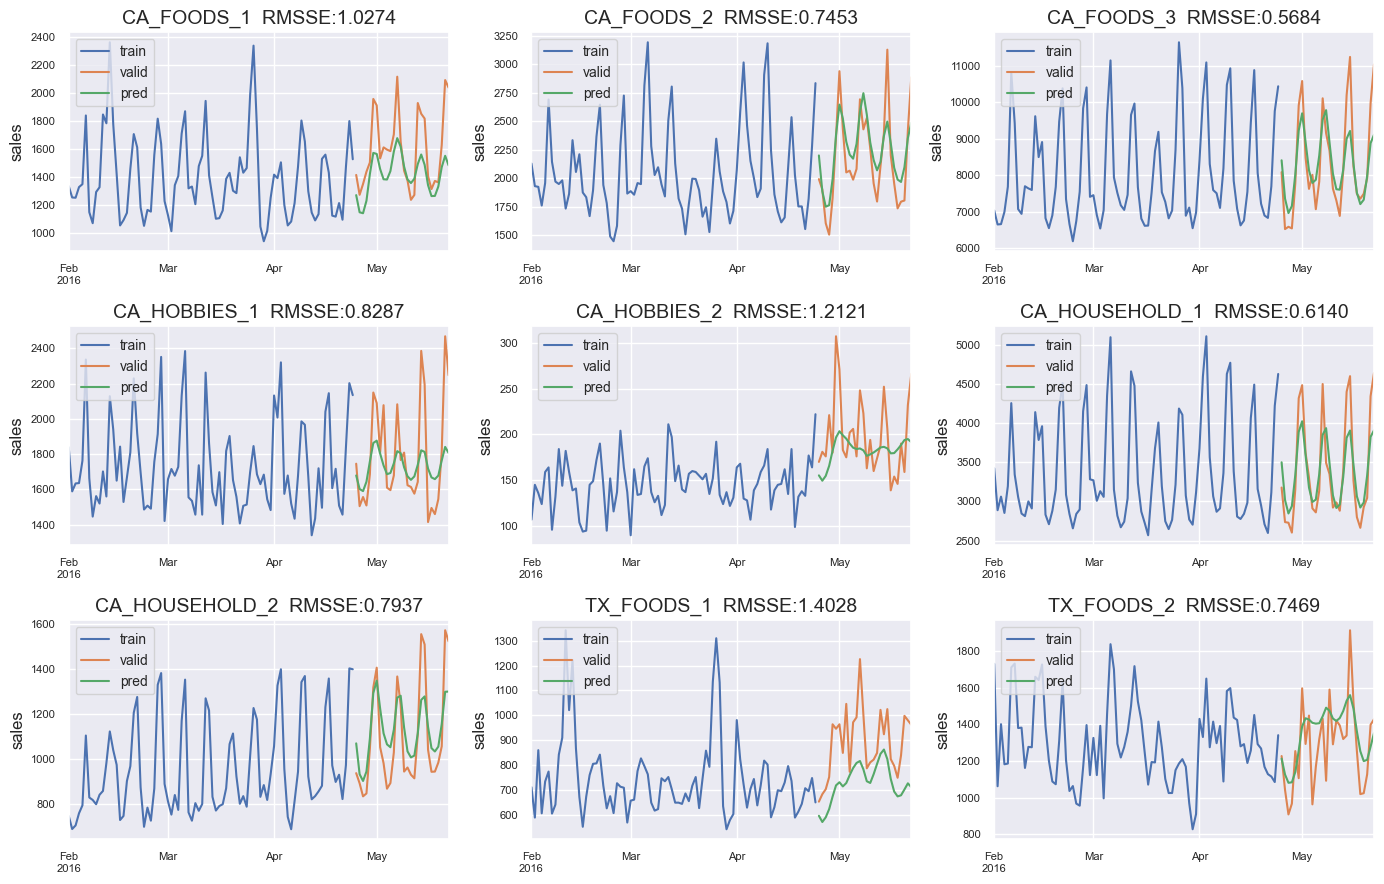

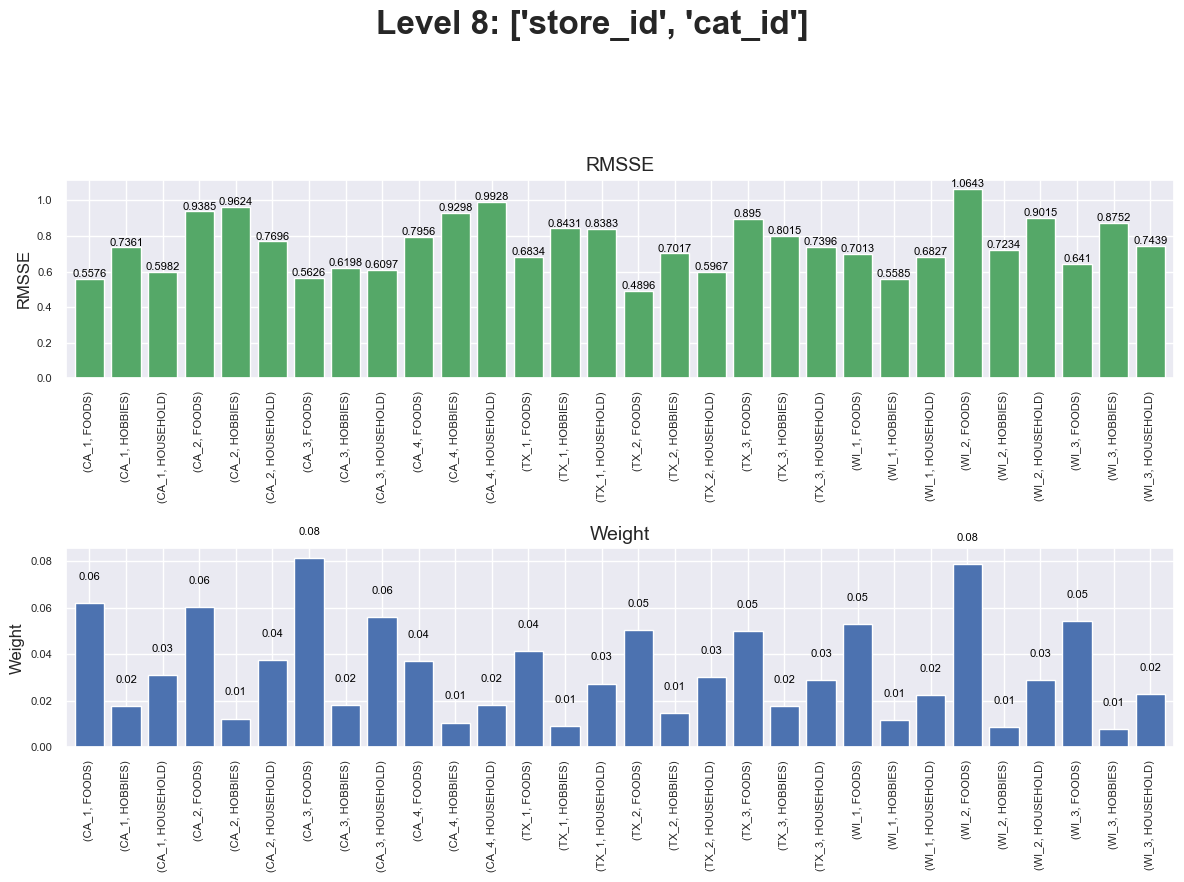

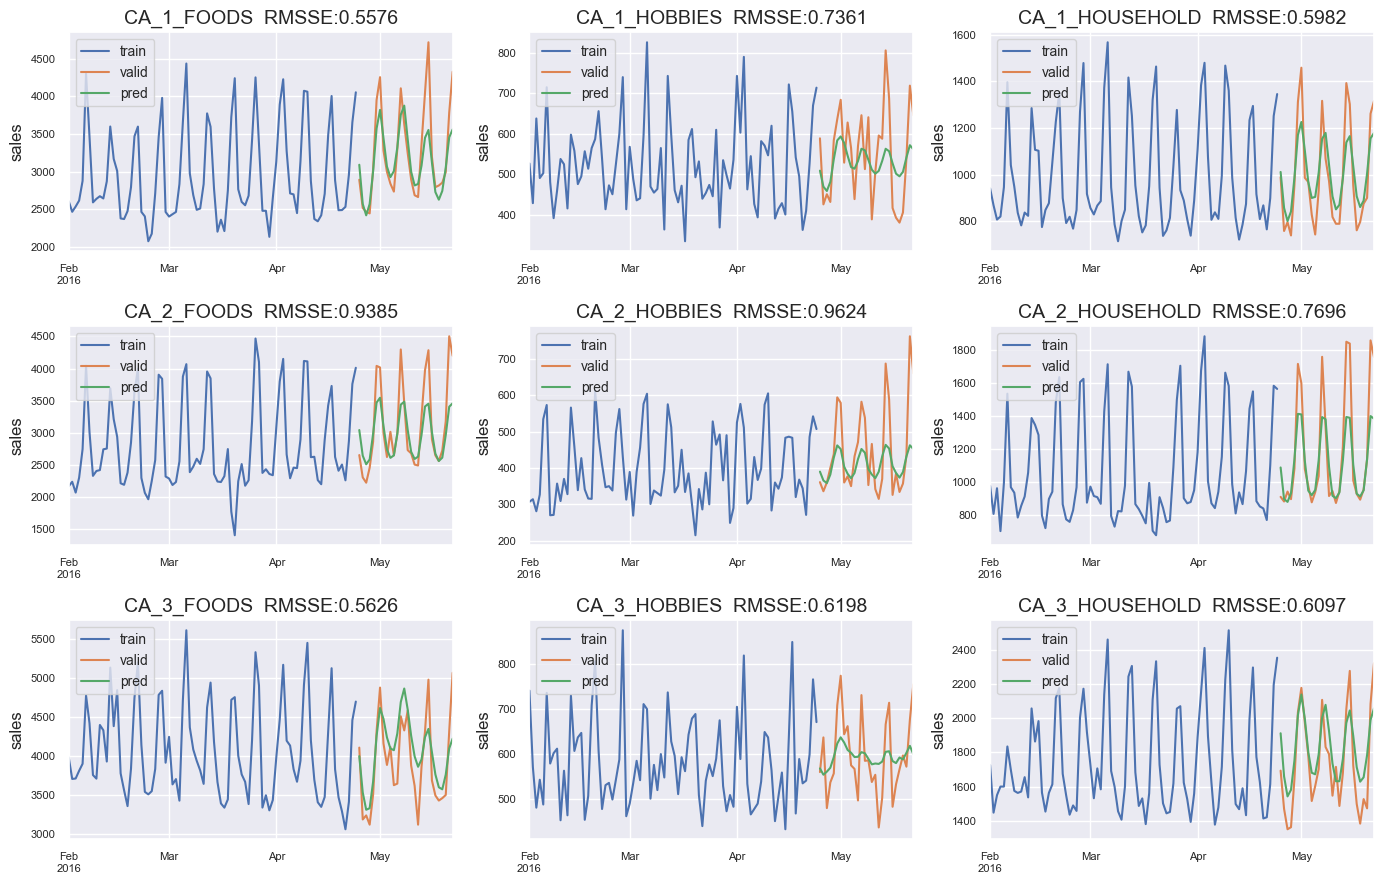

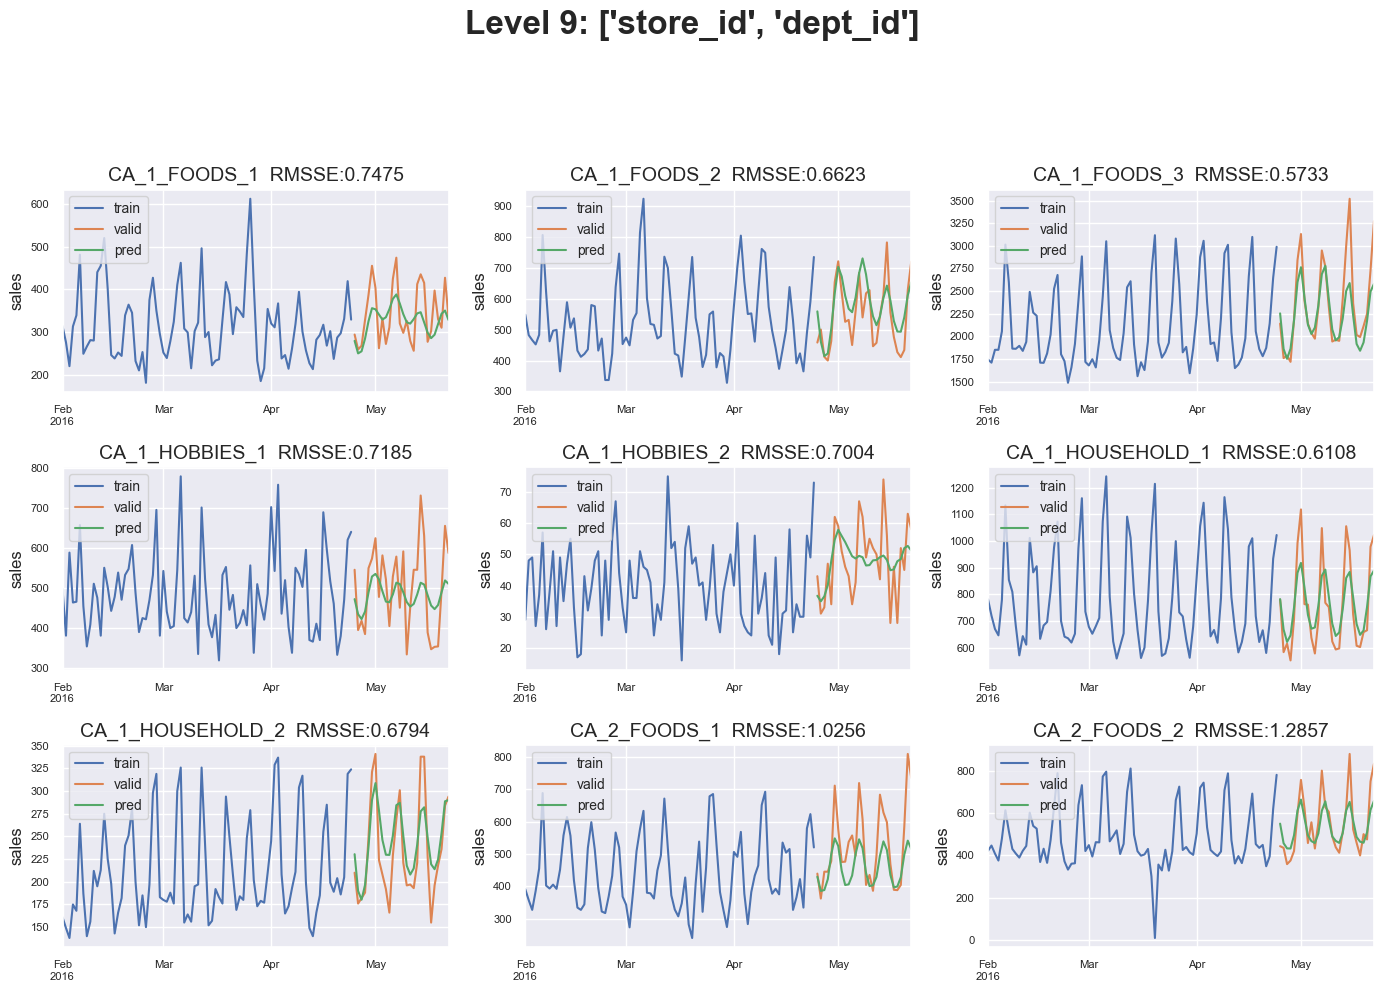

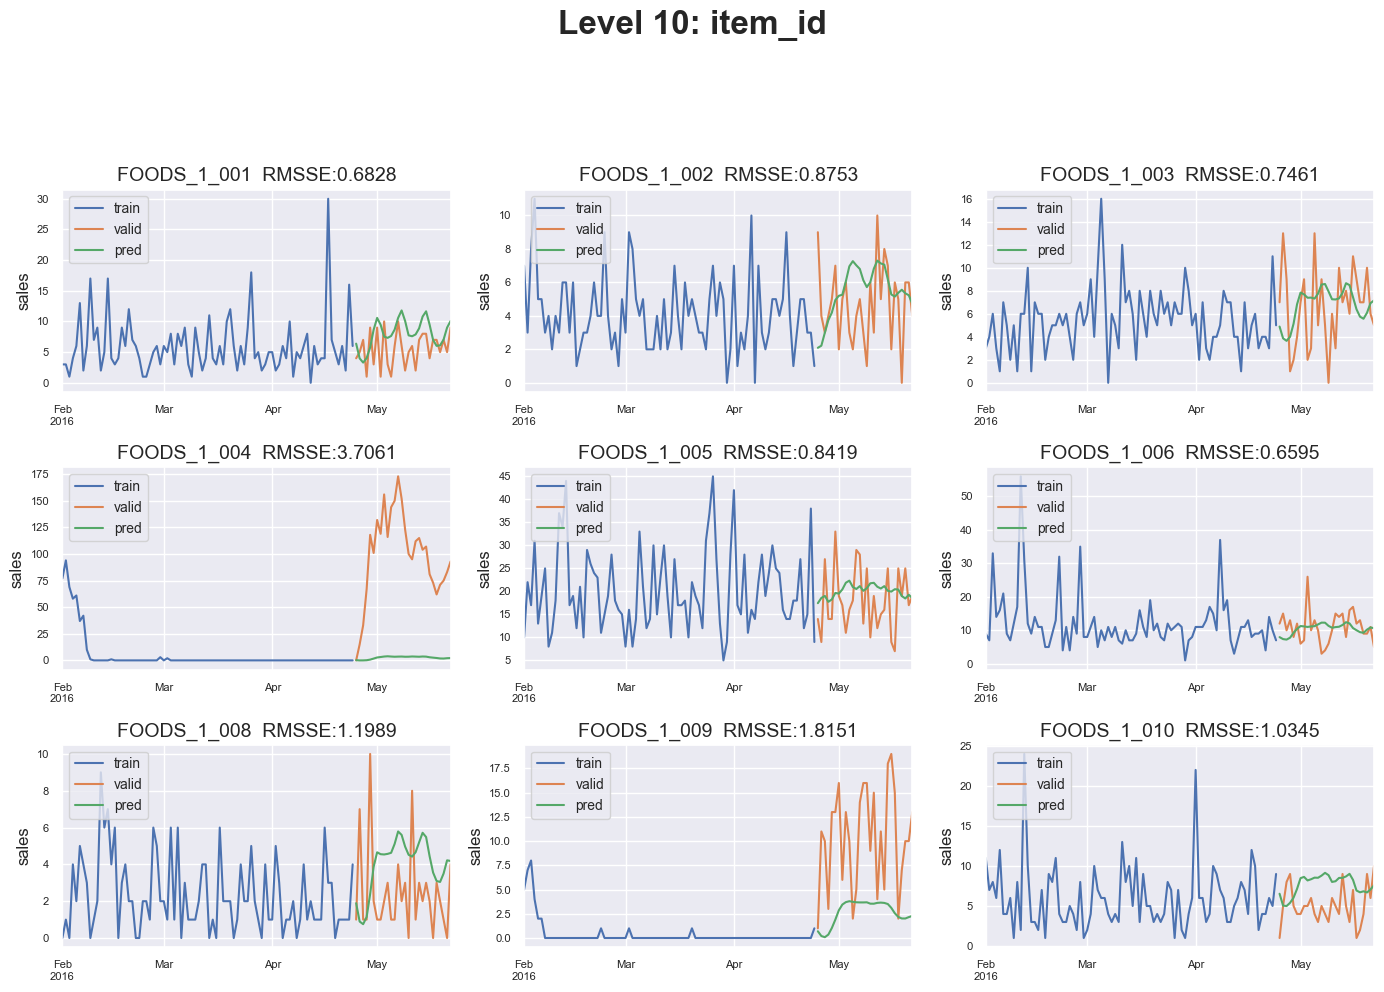

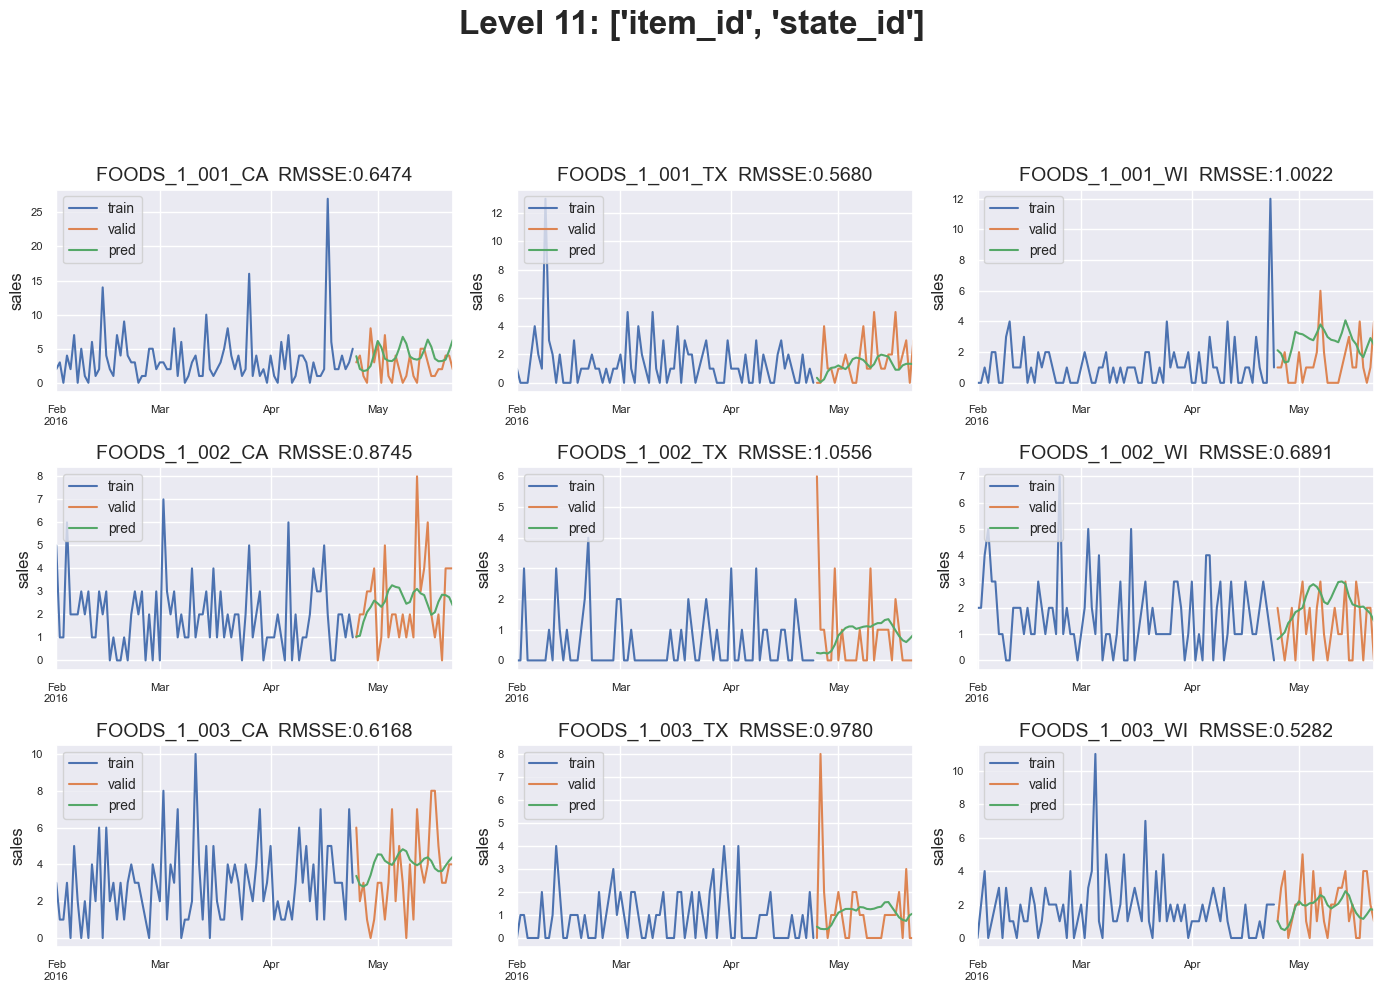

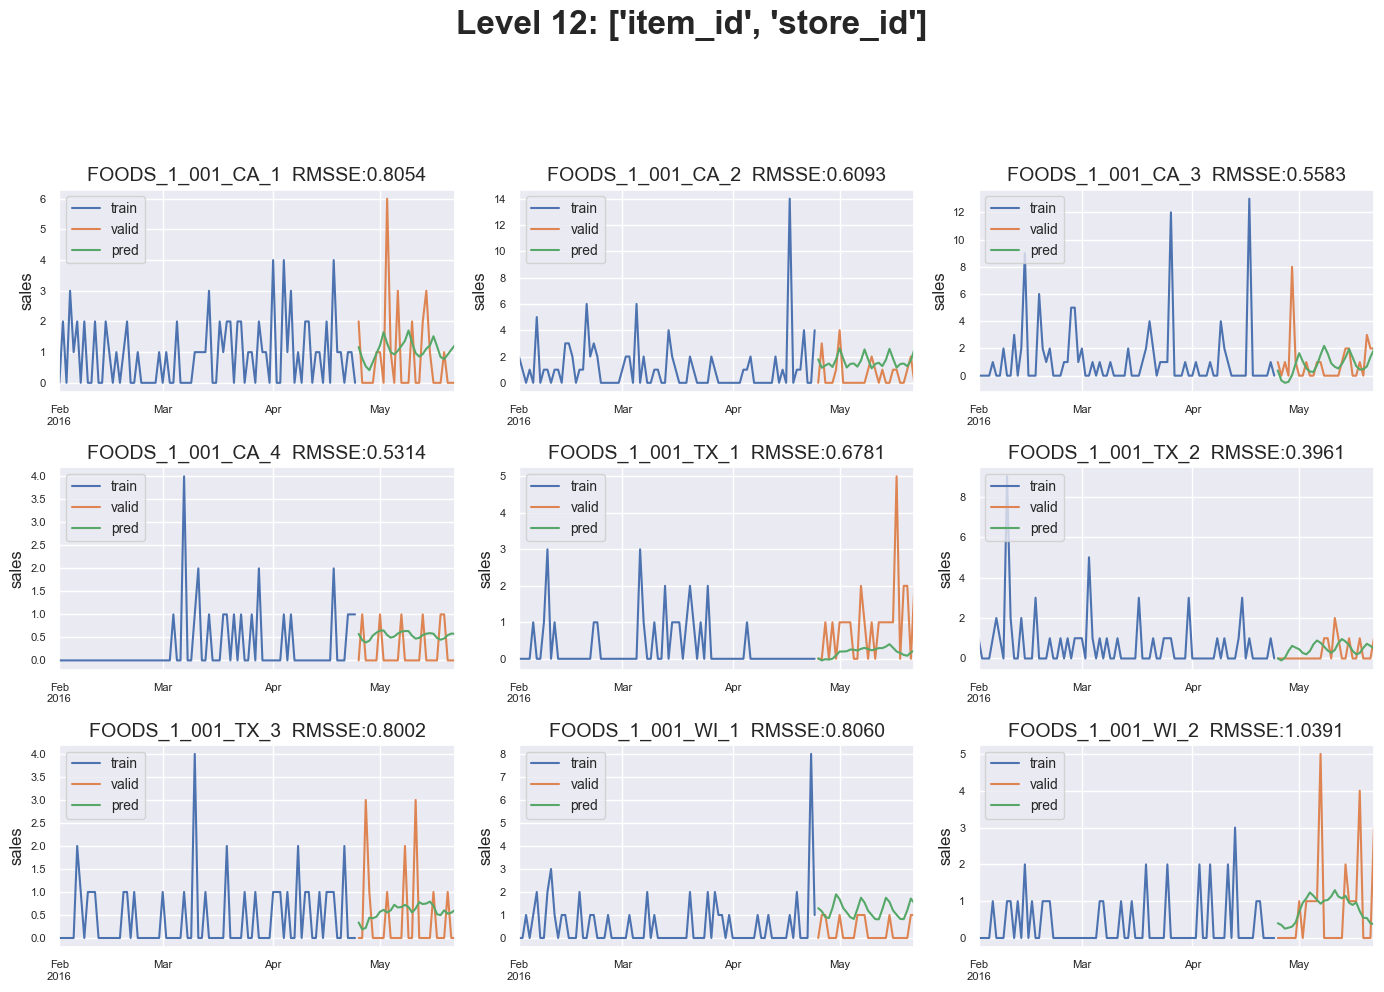

In [24]:
create_dashboard(evaluator)